# Conformal Methods: Width–Coverage (per process) + Mean Runtime (across processes)

This notebook is a mildly adjusted copy of Stocker, Massimo's notebook, which can be found at the following [link](https://github.com/massicy2004-arch/Conformal-forecasting-notebook/tree/bf078f92897d166b5530a0d130480b020bfd29ae). 

The original notebook simulates **three** processes (AR(1), ARMA(1,1), Mean-Shift),
runs several conformal methods (SCP, WCP variants, ACI, EnbPI), and produces:

- One **scatter per process**: coverage vs. average interval width (markers = methods/params).
- One **runtime bar chart**: *mean runtime across the three processes* (averaged over Monte Carlo runs).

We have adjusted the notebook by adding GARCH(1,1) as a fourth process, as well as producing plots with error bars. Error bars are generated using a confidence interval of 95%.

The base forecaster is **ARL** (linear autoregression with fixed lag order `p=3`).
Plots use matplotlib only and a single chart per figure (per the constraints).

In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
from time import perf_counter

rng = np.random.default_rng(12345)

# ---------- Simulation ----------
def simulate_ar1(n, phi=0.6, sigma=1.0, seed=None):
    r = np.random.default_rng(seed)
    y = np.zeros(n)
    eps = r.normal(0, sigma, size=n)
    for t in range(1, n):
        y[t] = phi * y[t-1] + eps[t]
    return y

def simulate_arma11(n, phi=0.5, theta=0.4, sigma=1.0, seed=None):
    r = np.random.default_rng(seed)
    y = np.zeros(n)
    eps = r.normal(0, sigma, size=n)
    for t in range(1, n):
        mae = eps[t-1] if t-1 >= 0 else 0.0
        y[t] = phi * y[t-1] + eps[t] + theta * mae
    return y

def simulate_mean_shift(n, shift_start, delta=1.0, sigma=1.0, seed=None):
    r = np.random.default_rng(seed)
    base = r.normal(0, sigma, size=n)
    y = base.copy()
    y[shift_start:] += delta
    # Add a small AR(1) component to keep some local dependence
    phi = 0.3
    for t in range(1, n):
        y[t] = phi*y[t-1] + (1.0-phi)*y[t]
    return y

# ---------- ARL base forecaster (p=3 by default) ----------
def build_design(y, p=3):
    # returns (X, target) using past p lags for autoregression with intercept
    n = len(y)
    if n <= p:
        raise ValueError("Not enough points for lagged design.")
    X = []
    target = []
    for t in range(p, n):
        X.append([1.0] + [y[t-k] for k in range(1, p+1)])  # intercept + lags
        target.append(y[t])
    return np.asarray(X), np.asarray(target)

def fit_ar_ols(y, p=3):
    X, target = build_design(y, p=p)
    beta, *_ = np.linalg.lstsq(X, target, rcond=None)
    return beta  # beta[0]=intercept, beta[1:]=lags

def predict_next(beta, y_hist, p=3):
    # y_hist: array-like with most recent value at index -1.
    if len(y_hist) < p:
        return y_hist[-1]  # fallback
    x = np.array([1.0] + [y_hist[-k] for k in range(1, p+1)])
    return float(x @ beta)

# ---------- Quantiles ----------
def weighted_quantile(values, quantile, sample_weight=None):
    values = np.asarray(values, dtype=float)
    if sample_weight is None:
        return np.quantile(values, quantile, method="linear")
    w = np.asarray(sample_weight, dtype=float)
    assert values.shape[0] == w.shape[0]
    sorter = np.argsort(values)
    v = values[sorter]
    w = w[sorter]
    cdf = np.cumsum(w) / np.sum(w)
    return float(np.interp(quantile, cdf, v))

# ---------- Methods ----------

def method_SCP_block(y, n_train, n_cal, n_test, alpha=0.1, p=3, step=1):
    # Train on first n_train; calibrate on next n_cal; predict next n_test
    
    # --- Subsample the training data ---
    y_train = y[:n_train][::step]
    
    # --- Fit model on subsampled training data ---
    # Note: fit_ar_ols will use all history points (not subsampled) within the subsampled data
    beta = fit_ar_ols(y_train, p=p)
    
    # Build residuals on calibration
    cal_series = y[:n_train + n_cal]
    
    # --- Create subsampled calibration indices and ground truth ---
    cal_indices = range(n_train, n_train + n_cal)[::step]
    y_cal_truth = y[n_train:n_train+n_cal][::step]
    
    preds_cal = []
    # --- Loop over subsampled calibration time points ---
    for t in cal_indices:
        y_hist = cal_series[:t]  # History is still the full history up to t
        preds_cal.append(predict_next(beta, y_hist, p=p))
        
    eps_cal = np.abs(y_cal_truth - np.array(preds_cal))
    
    # Handle empty calibration set if step is too large
    if len(eps_cal) == 0:
        print(f"Warning: No calibration points for step={step}. Returning (0, 0).")
        return 0, 0
        
    q = np.quantile(eps_cal, 1-alpha, method="linear")
    
    # Predict intervals on test
    
    # --- Create subsampled test indices and ground truth ---
    test_indices = range(n_train + n_cal, n_train + n_cal + n_test)[::step]
    y_test_truth = y[n_train+n_cal:n_train+n_cal+n_test][::step]
    
    intervals = []
    preds_test = []
    # --- Loop over subsampled test time points ---
    for t in test_indices:
        y_hist = y[:t] # History is still the full history up to t
        mu = predict_next(beta, y_hist, p=p)
        intervals.append((mu - q, mu + q))
        preds_test.append(mu)
        
    intervals = np.array(intervals)
    
    # Handle empty test set
    if len(y_test_truth) == 0:
        print(f"Warning: No test points for step={step}. Returning (0, 0).")
        return 0, 0
    
    # --- Calculate coverage and width on subsampled test set ---
    cov = np.mean((y_test_truth >= intervals[:,0]) &
                  (y_test_truth <= intervals[:,1]))
    width = np.mean(intervals[:,1] - intervals[:,0])
    return cov, width


def method_SCP(y, n_train, n_cal, n_test, alpha=0.1, p=3):
    # Train on first n_train; calibrate on next n_cal; predict next n_test
    beta = fit_ar_ols(y[:n_train], p=p)
    # Build residuals on calibration
    cal_series = y[:n_train + n_cal]
    preds_cal = []
    for t in range(n_train, n_train + n_cal):
        y_hist = cal_series[:t]  # up to t-1
        preds_cal.append(predict_next(beta, y_hist, p=p))
    eps_cal = np.abs(y[n_train:n_train+n_cal] - np.array(preds_cal))
    q = np.quantile(eps_cal, 1-alpha, method="linear")
    # Predict intervals on test
    intervals = []
    preds_test = []
    for t in range(n_train + n_cal, n_train + n_cal + n_test):
        y_hist = y[:t]
        mu = predict_next(beta, y_hist, p=p)
        intervals.append((mu - q, mu + q))
        preds_test.append(mu)
    intervals = np.array(intervals)
    cov = np.mean((y[n_train+n_cal:n_train+n_cal+n_test] >= intervals[:,0]) &
                  (y[n_train+n_cal:n_train+n_cal+n_test] <= intervals[:,1]))
    width = np.mean(intervals[:,1] - intervals[:,0])
    return cov, width

def method_WCP(y, n_train, n_cal, n_test, alpha=0.1, p=3, scheme="exp", rho=0.99, W=50):
    beta = fit_ar_ols(y[:n_train], p=p)
    cal_series = y[:n_train + n_cal]
    preds_cal = []
    for t in range(n_train, n_train + n_cal):
        preds_cal.append(predict_next(beta, cal_series[:t], p=p))
    eps_cal = np.abs(y[n_train:n_train+n_cal] - np.array(preds_cal))
    # weights (index from oldest=1 to newest=n_cal)
    idx = np.arange(1, n_cal+1)
    if scheme == "exp":
        w = rho**(n_cal - idx)
    elif scheme == "linear":
        w = idx
    elif scheme == "window":
        w = (idx > (n_cal - W)).astype(float)
    else:
        w = np.ones_like(idx, dtype=float)
    # include test weight 1 in normalization (per WCP design); here we only need eps quantile
    q = weighted_quantile(eps_cal, 1-alpha, sample_weight=w)
    # test intervals
    intervals = []
    for t in range(n_train + n_cal, n_train + n_cal + n_test):
        mu = predict_next(beta, y[:t], p=p)
        intervals.append((mu - q, mu + q))
    intervals = np.array(intervals)
    cov = np.mean((y[n_train+n_cal:n_train+n_cal+n_test] >= intervals[:,0]) &
                  (y[n_train+n_cal:n_train+n_cal+n_test] <= intervals[:,1]))
    width = np.mean(intervals[:,1] - intervals[:,0])
    return cov, width

def method_ACI(y, n_train, n_cal, n_test, alpha=0.1, gamma=0.005, p=3):
    beta = fit_ar_ols(y[:n_train], p=p)
    # init residual pool from calibration
    cal_series = y[:n_train + n_cal]
    preds_cal = []
    for t in range(n_train, n_train + n_cal):
        preds_cal.append(predict_next(beta, cal_series[:t], p=p))
    eps_pool = deque(np.abs(y[n_train:n_train+n_cal] - np.array(preds_cal)).tolist())
    # online
    alpha_t = alpha
    intervals = []
    preds_test = []
    for t in range(n_train + n_cal, n_train + n_cal + n_test):
        q = np.quantile(np.array(eps_pool), 1 - alpha_t, method="linear")
        mu = predict_next(beta, y[:t], p=p)
        intervals.append((mu - q, mu + q))
        preds_test.append(mu)
        # observe Y_t and update
        err = alpha - (0 if (y[t] >= mu - q and y[t] <= mu + q) else 1)
        alpha_t = np.clip(alpha_t + gamma * err, 1e-6, 1-1e-6)
        # update residual pool with |Y_t - mu|, pop oldest to keep size fixed
        eps_pool.append(abs(y[t] - mu))
        eps_pool.popleft()
    intervals = np.array(intervals)
    cov = np.mean((y[n_train+n_cal:n_train+n_cal+n_test] >= intervals[:,0]) &
                  (y[n_train+n_cal:n_train+n_cal+n_test] <= intervals[:,1]))
    width = np.mean(intervals[:,1] - intervals[:,0])
    return cov, width

def method_EnbPI(y, T, n_test, alpha=0.1, B=25, s=10, p=3):
    # Training window is y[:T]. Build B bootstrap AR models.
    n = len(y)
    idx = np.arange(T)
    # fit B models
    models = []
    boots = []
    for b in range(B):
        S_b = rng.choice(idx, size=T, replace=True)
        boots.append(S_b)
        beta_b = fit_ar_ols(y[S_b], p=p)
        models.append(beta_b)
    # Build OOB residuals for indices p..T-1
    eps = []
    for i in range(p, T):
        O_i = [b for b, S_b in enumerate(boots) if i not in S_b]
        if len(O_i)==0:
            preds = [models[b] for b in range(B)]
            mu_i = np.mean([predict_next(models[b], y[:i], p=p) for b in range(B)])
        else:
            mu_i = np.mean([predict_next(models[b], y[:i], p=p) for b in O_i])
        eps.append(abs(y[i] - mu_i))
    eps = deque(eps)  # sliding residual window (size ~ T-p)

    # Predict on test points sequentially
    intervals = []
    pending = []  # store (t, mu_t) awaiting reveal in batches of size s
    for t in range(T, T + n_test):
        mu_t = np.mean([predict_next(models[b], y[:t], p=p) for b in range(B)])
        q = np.quantile(np.array(list(eps)), 1-alpha, method="linear")
        intervals.append((mu_t - q, mu_t + q))
        pending.append((t, mu_t))
        # reveal every s steps
        if (t - T + 1) % s == 0:
            for (tt, mu_pred) in pending:
                eps.append(abs(y[tt] - mu_pred))
                # keep window roughly constant length by dropping from left
                if len(eps) > (T - p):
                    eps.popleft()
            pending = []
    intervals = np.array(intervals)
    cov = np.mean((y[T:T+n_test] >= intervals[:,0]) & (y[T:T+n_test] <= intervals[:,1]))
    width = np.mean(intervals[:,1] - intervals[:,0])
    return cov, width


#### Additional GARCH(1,1) Model and Error Bars Functions

In [2]:
from scipy import stats

def simulate_garch(n, omega=0.3, alpha=0.5, beta=0.1, sigma=1.0, seed=None):
  # for a heteroskedastic (non-constant variance) error term
  r = np.random.default_rng(seed)
  y = np.zeros(n)
  eps = r.normal(0, sigma, size=n)
  for t in range(1, n):
    y[t] = eps[t] * np.sqrt(omega + (alpha * y[t-1]**2) + (beta * sigma**2))
  return y

# ---------- Error Bars -------
def error_bars_confidence(mean, std, n, confidence):
  df = n-1
  tsc = stats.t.ppf(1 - confidence/2, df)
  lol = std / np.sqrt(n+1)
  res = tsc * lol
  return res

def error_bars_prediction(mean, std, n, confidence):
  df = n-1
  tsc = stats.t.ppf(1 - confidence/2, df)
  res = tsc * std
  return res

In [14]:

# ---------- Experiment settings ----------
n_total = 900
n_train = 300
n_cal   = 300
n_test  = 300
alpha   = 0.10
p_lags  = 3
B_boot  = 25
batch_sizes = [1, 10, 100]
gammas = [0.001, 0.005, 0.01]
steps = [2,3]
wcp_schemes = [("WCP-exp", {"scheme":"exp","rho":0.99}),
               ("WCP-linear", {"scheme":"linear"}),
               ("WCP-window", {"scheme":"window","W":50})]

N_MC = 50  # Monte Carlo repetitions

processes = [
    ("AR(1)", lambda seed: simulate_ar1(n_total, phi=0.6, sigma=1.0, seed=seed)),
    ("ARMA(1,1)", lambda seed: simulate_arma11(n_total, phi=0.5, theta=0.4, sigma=1.0, seed=seed)),
    ("Mean-Shift", lambda seed: simulate_mean_shift(n_total, shift_start=n_train + n_cal//2, delta=1.0, sigma=1.0, seed=seed)),
    ("GARCH(1,1)", lambda seed: simulate_garch(n_total, omega=0.3, alpha=0.5, beta=0.1, sigma=1.0, seed=seed))
]


In [27]:

rows = []

for proc_name, gen in processes:
    for run in range(N_MC):
        seed = 10_000 + 100*run
        y = gen(seed)

        # ----- SCP -----
        t0 = perf_counter()
        cov, wid = method_SCP(y, n_train, n_cal, n_test, alpha=alpha, p=p_lags)
        rt = perf_counter() - t0
        rows.append({"process": proc_name, "method": "SCP", "param": "",
                     "coverage": cov, "width": wid, "runtime": rt})
        
        # blocked conformal prediction
        for s in steps:
            t0 = perf_counter()
            cov, wid = method_SCP_block(y, n_train, n_cal, n_test, alpha=alpha, p=p_lags, step=s)
            rt = perf_counter() - t0
            rows.append({"process": proc_name, "method": "SCP-block", "param": f"B={s}",
                         "coverage": cov, "width": wid, "runtime": rt})


        # ----- WCP variants -----
        for label, kwargs in wcp_schemes:
            t0 = perf_counter()
            cov, wid = method_WCP(y, n_train, n_cal, n_test, alpha=alpha, p=p_lags, **kwargs)
            rt = perf_counter() - t0
            rows.append({"process": proc_name, "method": label, "param": "",
                         "coverage": cov, "width": wid, "runtime": rt})

        # ----- ACI (three gammas) -----
        for g in gammas:
            t0 = perf_counter()
            cov, wid = method_ACI(y, n_train, n_cal, n_test, alpha=alpha, gamma=g, p=p_lags)
            rt = perf_counter() - t0
            rows.append({"process": proc_name, "method": "ACI", "param": f"gamma={g}",
                         "coverage": cov, "width": wid, "runtime": rt})

        # ----- EnbPI (three batch sizes) -----
        T_window = n_train + n_cal
        for s in batch_sizes:
            t0 = perf_counter()
            cov, wid = method_EnbPI(y, T_window, n_test, alpha=alpha, B=B_boot, s=s, p=p_lags)
            rt = perf_counter() - t0
            rows.append({"process": proc_name, "method": "EnbPI", "param": f"s={s}",
                         "coverage": cov, "width": wid, "runtime": rt})
 
results = pd.DataFrame(rows)
results_head = results.head(10)
results_head


,process,method,param,coverage,width,runtime
0,AR(1),SCP,,0.900000,3.248716,0.004210
1,AR(1),SCP-block,B=2,0.906667,3.691960,0.001997
2,AR(1),SCP-block,B=3,0.890000,4.390722,0.001235
3,AR(1),WCP-exp,,0.896667,3.155067,0.004547
4,AR(1),WCP-linear,,0.896667,3.185017,0.006858
5,AR(1),WCP-window,,0.896667,3.151807,0.007266
6,AR(1),ACI,gamma=0.001,0.890000,3.121778,0.108236
7,AR(1),ACI,gamma=0.005,0.896667,3.085247,0.050262
8,AR(1),ACI,gamma=0.01,0.893333,3.149332,0.057103
9,AR(1),EnbPI,s=1,0.873333,4.088151,0.355924


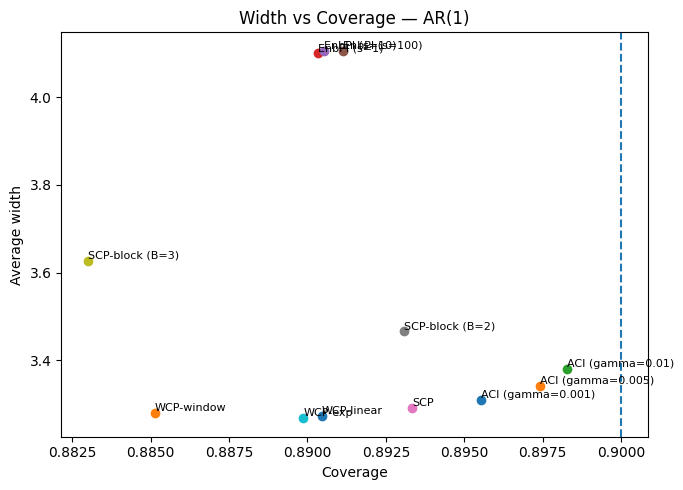

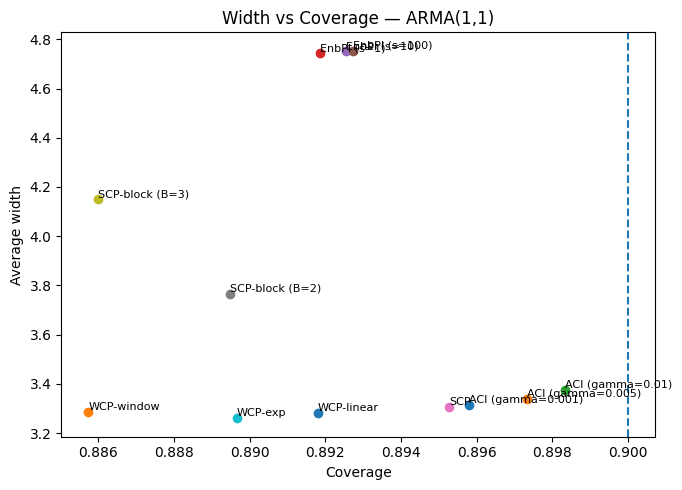

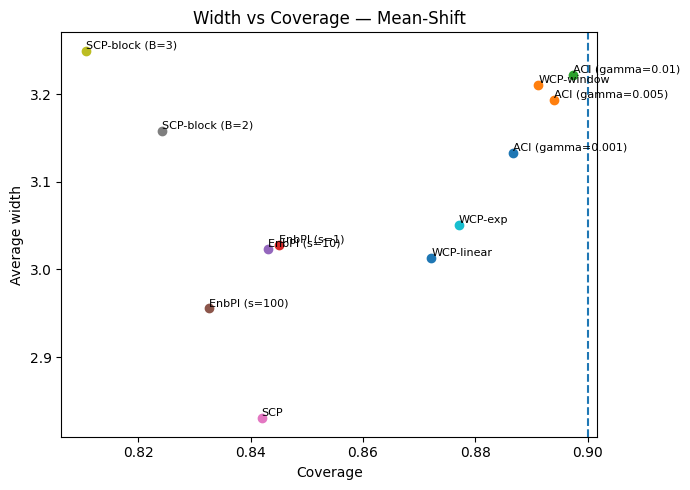

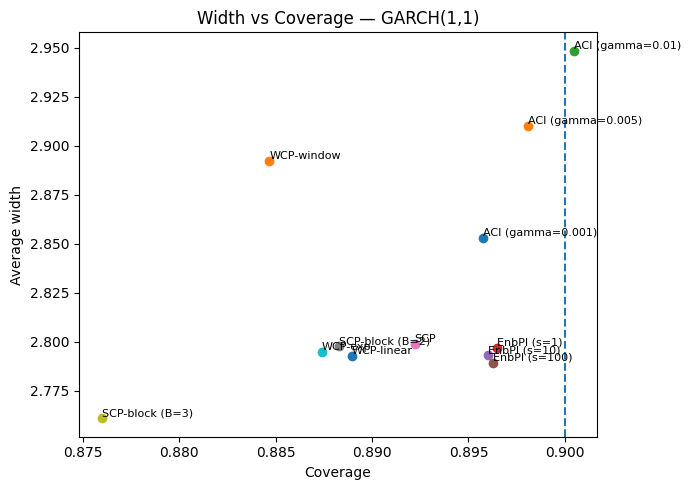

In [28]:

# One scatter per process: coverage vs average width
for proc_name in results["process"].unique():
    dfp = results[results["process"] == proc_name].copy()
    # aggregate over MC runs (mean coverage/width per method+param)
    agg = dfp.groupby(["method","param"], as_index=False)[["coverage","width"]].mean()

    plt.figure(figsize=(7,5))
    for _, row in agg.iterrows():
        label = row["method"] if row["param"]=="" else f'{row["method"]} ({row["param"]})'
        plt.scatter(row["coverage"], row["width"], label=label)
        # small text for readability
        plt.text(row["coverage"], row["width"], label, fontsize=8, ha="left", va="bottom")
    plt.axvline(1 - alpha, linestyle="--")
    plt.title(f"Width vs Coverage — {proc_name}")
    plt.xlabel("Coverage")
    plt.ylabel("Average width")
    plt.tight_layout()
    plt.savefig(f"{proc_name}-SIMPLE")
    plt.show()


#### Adjusted Plots for Smaller Amount of Whitespace + Error Bars

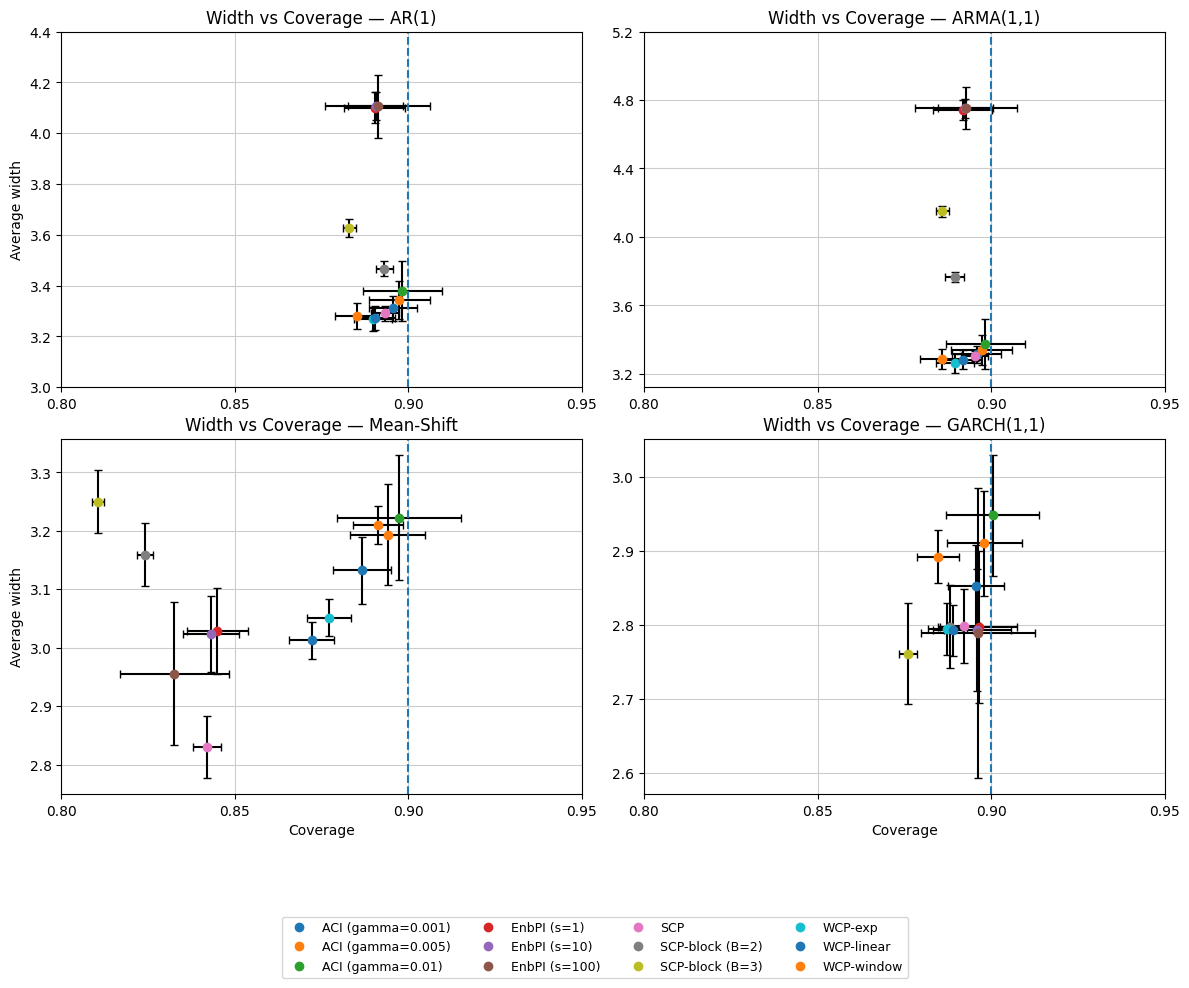

In [30]:
from matplotlib import container
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Start of modified code ---

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Get the unique process names
process_list = results["process"].unique()

# Dictionary to hold unique handles and labels for the shared legend
handles_dict = {}

# Iterate over the processes and their corresponding axes
for i, proc_name in enumerate(process_list):
    # Select the correct subplot axis (0,0), (0,1), (1,0), (1,1)
    ax = axes.flat[i]

    dfp = results[results["process"] == proc_name].copy()
    
    # --- This part is the same as the original ---
    unique_pairs = dfp[['method', 'param']].drop_duplicates()
    err = []
    for method in unique_pairs.iterrows():
        # 1. filter subsets for each method
        # Note: The .iloc[0] and .iloc[1] are used to access by position,
        # as the original code's method[1][0] and method[1][1] might be ambiguous
        res = dfp[(dfp['method'] == method[1].iloc[0]) & (dfp['param'] == method[1].iloc[1])]

        # 2. for each subset, calc error bands
        cov_err = error_bars_confidence(np.mean(res['coverage']), np.std(res['coverage']), len(res), 0.05)
        width_err = error_bars_confidence(np.mean(res['width']), np.std(res['width']), len(res), 0.05)
        err.append([cov_err, width_err])

    # aggregate over MC runs (mean coverage/width per method+param)
    agg = dfp.groupby(["method","param"], as_index=False)[["coverage","width"]].mean()
    agg[['cov_err', 'width_err']] = err
    
    # print(agg) # This was in the original, uncomment if you need it

    # Plot on the specific axis 'ax'
    for _, row in agg.iterrows():
        label = row["method"] if row["param"] == "" else f'{row["method"]} ({row["param"]})'
        
        # Use ax.errorbar and explicitly pass xerr and yerr
        eb = ax.errorbar(
            row["coverage"], row["width"],
            yerr=row["width_err"], xerr=row["cov_err"], # Fixed to use row's data
            ecolor='black', capsize=3, fmt='o',
            label=label
        )
        
        # Store the handle and label for the shared legend
        if label not in handles_dict:
            handles_dict[label] = eb

    # --- Apply customizations to the specific axis 'ax' ---
    
    # Set title for the subplot
    ax.set_title(f"Width vs Coverage — {proc_name}")
    
    # Add grid
    ax.grid(True, color="0.8")

    # Add vertical line
    ax.axvline(1 - alpha, linestyle="--") 

    # Set Y-ticks (from original logic)
    if proc_name == 'AR(1)':
        ax.set_yticks(np.arange(3, 4.4, 0.2))
    elif proc_name == 'ARMA(1,1)':
        ax.set_yticks(np.arange(3.2, 5.6, 0.4))
    # You can add elif for 'Mean-Shift' and 'GARCH(1,1)' if needed

    # Set X-axis limits and ticks (User Request)
    ax.set_xlim(0.8, 0.95)
    ax.set_xticks(np.arange(0.8, 0.951, 0.05)) # Use 0.951 to include 0.95

    # Set labels only for outer plots
    if i in [0, 2]: # Left column
        ax.set_ylabel("Average width")
    if i in [2, 3]: # Bottom row
        ax.set_xlabel("Coverage")

# --- After the loop, create the shared legend ---

# Get the handles and labels from the dictionary
handles = handles_dict.values()
labels = handles_dict.keys()

# Filter handles (from original logic)
new_handles = []
for h in handles:
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])
    else:
        new_handles.append(h)

# Add the shared legend to the figure (bottom center)
# We set ncol to 5 for a 2-row legend, or 10 for a single row.
fig.legend(new_handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=4, fontsize=9)

# Adjust layout to prevent overlap and make space for legend
plt.tight_layout()
fig.subplots_adjust(bottom=0.2) # Increase bottom margin for legend

# Save and show the single figure
plt.savefig('all_processes_grid.png')
plt.show()

# --- End of modified code ---

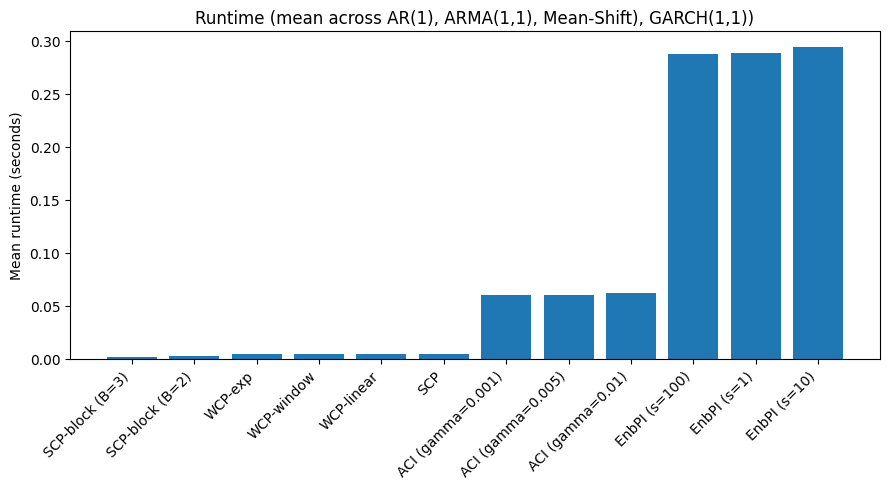

In [31]:

# Mean runtime across the three processes (and across MC runs)
# We aggregate per (method, param), then average over processes.
agg_proc = results.groupby(["process","method","param"], as_index=False)["runtime"].mean()
mean_over_processes = agg_proc.groupby(["method","param"], as_index=False)["runtime"].mean()
mean_over_processes["label"] = mean_over_processes.apply(
    lambda r: r["method"] if (r["param"]=="" or pd.isna(r["param"])) else f'{r["method"]} ({r["param"]})', axis=1
)

plt.figure(figsize=(9,5))
order = mean_over_processes.sort_values("runtime")["label"].tolist()
vals = mean_over_processes.set_index("label").loc[order]["runtime"].values
xpos = np.arange(len(order))
plt.bar(xpos, vals)
plt.xticks(xpos, order, rotation=45, ha="right")
plt.ylabel("Mean runtime (seconds)")
plt.title("Runtime (mean across AR(1), ARMA(1,1), Mean-Shift), GARCH(1,1))")
plt.tight_layout()
plt.savefig('runtime.png')
plt.show()
